<a href="https://colab.research.google.com/github/PapSara/PI/blob/main/lab8_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


read 1114 examples
read 1078 examples
loss 2.797, train acc 67.874, test acc 72.900
loss 2.333, train acc 72.893, test acc 72.828
loss 1.967, train acc 72.783, test acc 72.770
loss 1.712, train acc 72.744, test acc 72.884
loss 1.554, train acc 72.732, test acc 72.958


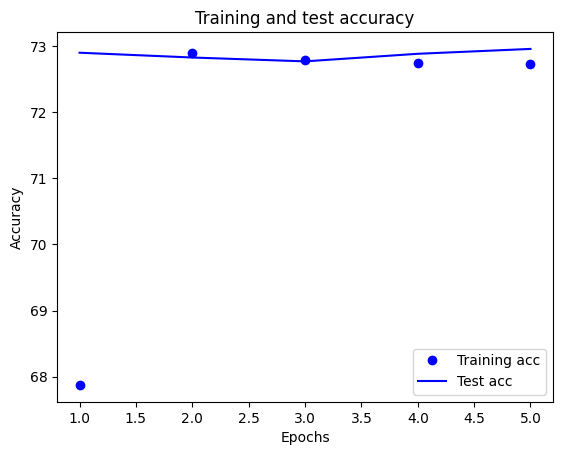

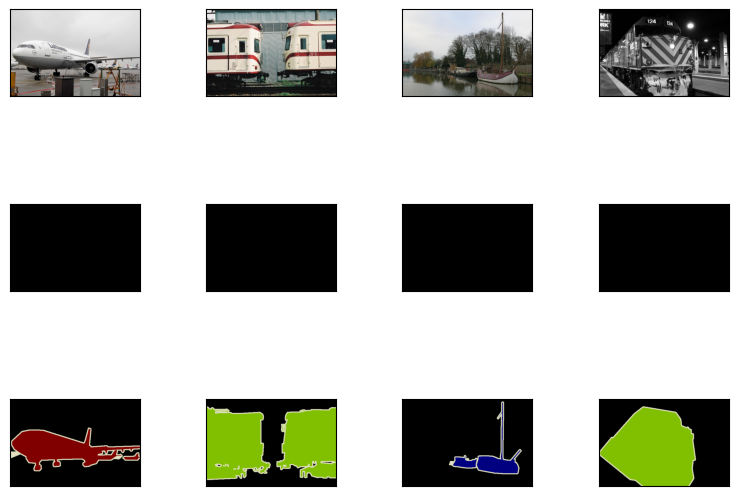

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from PIL import Image
from matplotlib import pyplot as plt
import os
import requests
import zipfile
import tarfile

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    plt.tight_layout()
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(url, folder=None):
    """Download and extract a zip file."""
    fname = download(url)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    voc_dir = download_extract('http://d2l-data.s3-accelerate.amazonaws.com/VOCtrainval_11-May-2012.tar', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = 2
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

pretrained_net = torchvision.models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights.DEFAULT)

net = nn.Sequential(*list(pretrained_net.children())[:-2])

num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

nn.init.xavier_uniform_(net.transpose_conv.weight.data)

batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = load_data_voc(batch_size, crop_size) #1 min

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax(y_hat, axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            total_hits += accuracy(net(X), y)
            total_samples += y.numel()
    return total_hits / total_samples * 100

def train_batch(net, X, y, loss, trainer, device):
    X = X.to(device)
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               device=try_gpu()):
    num_batches = len(train_iter)
    train_loss_all = []
    train_acc_all = []
    test_acc_all = []
    net = net.to(device)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        total_loss = 0
        total_acc = 0
        total_samples = 0
        total_predictions = 0
        for i, (features, labels) in enumerate(train_iter):
            l, acc = train_batch(
                net, features, labels, loss, trainer, device)
            total_loss += l
            total_acc += acc
            total_samples += labels.shape[0]
            total_predictions += labels.numel()
        train_loss_all.append(total_loss / total_samples)
        train_acc_all.append(total_acc / total_predictions * 100)
        test_acc = evaluate_accuracy(net, test_iter)
        test_acc_all.append(test_acc)
        print(f'loss {total_loss / total_samples:.3f}, train acc '
            f'{total_acc / total_predictions * 100:.3f}, test acc {test_acc:.3f}')
    return train_acc_all, test_acc_all

def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, device = 5, 0.001, 1e-3, try_gpu()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
train_acc_all, test_acc_all = train(net, train_iter, test_iter, loss, trainer, num_epochs, device) #6 min

def plot_accuracy(train_acc_all, test_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, test_acc_all, 'b', label='Test acc')
    plt.title('Training and test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(train_acc_all, test_acc_all)

def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(device)).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

def label2image(pred):
    colormap = torch.tensor(VOC_COLORMAP, device=device)
    X = pred.long()
    return colormap[X, :]

voc_dir = download_extract('http://d2l-data.s3-accelerate.amazonaws.com/VOCtrainval_11-May-2012.tar', 'VOCdevkit/VOC2012')
test_images, test_labels = read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]

show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2); #1 min